 # Cardiovascular Diseases - Heart Failure Prediction
    
   Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives
   each year, which accounts for 31% of all deaths worlwide. Heart failure is a common event caused by CVDs and this
   dataset contains 12 features that can be used to predict mortality by heart failure.

   Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.

   People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk
   factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and
   management wherein a machine learning model can be of great help.
    

    
 ## Dataset Link

[1] https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5#Sec2

[2] https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0181001#sec010

 ## Dataset Description

 Feature | Explanation | Measurement	| Range
------------- | ------------- |------------- | -------------
Age	|Age of the patient	|Years |	[40,..., 95]
Anaemia	|Decrease of red <br> blood cells or hemoglobin |	Boolean|	0, 1
High blood pressure |	If a patient has hypertension |	Boolean	 |0, 1
Creatinine phosphokinase<br>(CPK) |	Level of the CPK enzyme <br>in the blood |	mcg/L|	[23,..., 7861]
Diabetes|	If the patient has diabetes |	Boolean	| 0, 1
Ejection fraction|	Percentage of blood leaving<br>the heart at each contraction|Percentage	|	[14,..., 80]
Sex	| Woman or man |	Binary|	0, 1
Platelets|	Platelets in the blood|	kiloplatelets/mL|	[25.01,..., 850.00]
Serum creatinine|	Level of creatinine in the blood|	mg/dL|	[0.50,..., 9.40]
Serum sodium|	Level of sodium in the blood|	mEq/L|	[114,..., 148]
Smoking|	If the patient smokes|	Boolean	|0, 1
Time|	Follow-up period|	Days|	[4,...,285]
DEATH EVENT<br>(TARGET)|	If the patient died during the follow-up period|	Boolean|	0, 1

**NOTE: mcg/L: micrograms per liter. mL: microliter. mEq/L: milliequivalents per litre**

 ### References

    Machine learning can predict survival of patients with heart failure from serum creatinine and
    ejection fraction alone. (03 February 2020)
   https://doi.org/10.1186/s12911-020-1023-5

### Required Libraries and Utilities

In [44]:
# Import the required libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

!pip install lightgbm xgboost imbalanced-learn

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score, matthews_corrcoef
from sklearn.metrics import precision_score, auc, roc_auc_score, roc_curve, precision_recall_curve, classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from scipy.stats import randint

from imblearn.over_sampling import SMOTE
from collections import Counter

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [45]:
from ReusableUtils import ReusableUtils
utils = ReusableUtils()

### Set Notebook Configuration Parameters

In [46]:
utils.setNotebookConfigParams()

### Utility Functions

### Import Data

In [47]:
heart_faliure_data = pd.read_csv(filepath_or_buffer = './heart_failure_clinical_records_dataset.csv',
                                 low_memory = False,
                                 skipinitialspace = True,
                                 float_precision = 'round_trip')

heart_faliure_data.head()

age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  smoking  time  DEATH_EVENT
0  75.0        0                       582         0                 20                    1  265000.00               1.9           130    1        0     4            1
1  55.0        0                      7861         0                 38                    0  263358.03               1.1           136    1        0     6            1
2  65.0        0                       146         0                 20                    0  162000.00               1.3           129    1        1     7            1
3  50.0        1                       111         0                 20                    0  210000.00               1.9           137    1        0     7            1
4  65.0        1                       160         1                 20                    0  327000.00               2.7           116    0        0     8            1

In [48]:
heart_faliure_data.shape

(299, 13)

In [49]:
# Check the total missing values in each column.
print("Total NULL Values in each columns")
print("*********************************")
print(heart_faliure_data.isnull().sum())

Total NULL Values in each columns
*********************************
age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


***This looks to be a clean dataset without any missing values...***

In [50]:
heart_faliure_data.describe().T

count           mean           std      min       25%       50%       75%       max
age                       299.0      60.833893     11.894809     40.0      51.0      60.0      70.0      95.0
anaemia                   299.0       0.431438      0.496107      0.0       0.0       0.0       1.0       1.0
creatinine_phosphokinase  299.0     581.839465    970.287881     23.0     116.5     250.0     582.0    7861.0
diabetes                  299.0       0.418060      0.494067      0.0       0.0       0.0       1.0       1.0
ejection_fraction         299.0      38.083612     11.834841     14.0      30.0      38.0      45.0      80.0
high_blood_pressure       299.0       0.351171      0.478136      0.0       0.0       0.0       1.0       1.0
platelets                 299.0  263358.029264  97804.236869  25100.0  212500.0  262000.0  303500.0  850000.0
serum_creatinine          299.0       1.393880      1.034510      0.5       0.9       1.1       1.4       9.4
serum_sodium              299.0     136.625418      4.412477    113.0     134.0     137.0     140.0     148.0
sex                       299.0       0.648829      0.478136      0.0       0.0       1.0       1.0       1.0
smoking                   299.0       0.321070      0.467670      0.0       0.0       0.0       1.0       1.0
time                      299.0     130.260870     77.614208      4.0      73.0     115.0     203.0     285.0
DEATH_EVENT               299.0       0.321070      0.467670      0.0       0.0       0.0       1.0       1.0

## Data Preparation

### Test - Train Split

In [51]:
# X = heart_faliure_data[['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium',
#  'creatinine_phosphokinase']]

# X = heart_faliure_data[['age', 'ejection_fraction','serum_creatinine', 'serum_sodium']]

X = heart_faliure_data[['ejection_fraction', 'serum_creatinine', 'age']]

# X = heart_faliure_data[['age','ejection_fraction','serum_sodium']]

y = heart_faliure_data[['DEATH_EVENT']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.90, test_size = 0.10, random_state = 109)

print("X_Train Shape:", X_train.shape)
print("Y_Train Shape:", y_train.shape)
print("X_Test Shape:", X_test.shape)
print("Y_Test Shape:", y_test.shape)

X_Train Shape: (269, 3)
Y_Train Shape: (269, 1)
X_Test Shape: (30, 3)
Y_Test Shape: (30, 1)


#### Data Value Counts

In [52]:
print('Original dataset shape %s' % Counter(y_train.values.ravel()))

Original dataset shape Counter({np.int64(0): 186, np.int64(1): 83})


#### <font color = brown>Data Insight 17:</font>

**`1. As we see in the training data, the number of 1s (83 - Death Event) are much less comapred to the number of 0s (171 - Survival Case). This is also confirmed in the Data Insight 15.`**

**`2. With this imbalance dataset (67.89% survival cases & 32.11% death events), the model could become more inclined towards learnign and predicting the negative examples than the positive (death) cases.`**

**`3. To avoid this scenario and create an un-biased model, the dataset should be balanced where we need to generate more  examples of the minority class. We will apply the Synthetic Minority Oversampling Technique (SMOTE) algorithm on the training data such that more examples of the death events are generated and we have a balanced dataset.`**

In [53]:
print('Original dataset shape %s' % Counter(y_train.values.ravel()))

Original dataset shape Counter({np.int64(0): 186, np.int64(1): 83})


In [54]:
data_features = dict(enumerate(X.columns))
data_features

{0: 'ejection_fraction', 1: 'serum_creatinine', 2: 'age'}

#### Synthetic Minority Oversampling Technique (SMOTE)

In [55]:
# Implement SMOTE
sampling = SMOTE(random_state = 100)
X_train, y_train = sampling.fit_resample(X_train.values, y_train.values.ravel())

# Shuffle the data
perms = np.random.permutation(X_train.shape[0])
X_train = X_train[perms]
y_train = y_train[perms]

X_train = pd.DataFrame(data = X_train)
y_train = pd.DataFrame(data = y_train)

print(X_train.shape)
print(y_train.shape)

(372, 3)
(372, 1)


In [56]:
print('Resampled dataset shape %s' % Counter(y_train.values.ravel()))
print('Test dataset shape %s' % Counter(y_test.values.ravel()))

Resampled dataset shape Counter({np.int64(1): 186, np.int64(0): 186})
Test dataset shape Counter({np.int64(0): 17, np.int64(1): 13})


#### <font color = brown>Data Balancing Significance</font>

**`1. With the application of SMOTE on the training data, the number of 1s (Death Event) are now equal to the number of 0s (Survival Case) with each 171 records respectively.`**

- **2. This will ensure  -**
    - 2.1 There are equal data points for both positive and negative scenarios and we have a balanced dataset.
    - 2.2 The model will not be biased during training phase by seeing more example of Survival scenarios.


### Data Normalization

In [57]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Model Building & Training

To predict patients survival due to heart failure, we will train models from different machine learning algorithms. The classifiers to be used in this study will be -

**`1. Support Vector Machines with RBF kernel`**

**`2. Decision Tree`**

**`3. Random Forest`**

**`4. Gradient Boosting - XGBoost`**

**`5. Light GBM`**

## 1. Support Vector Machines with RBF kernel

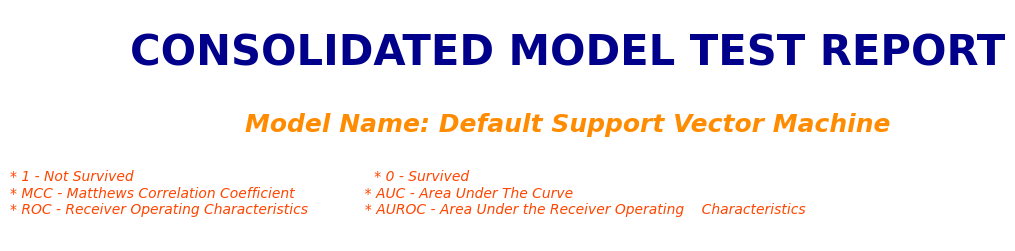

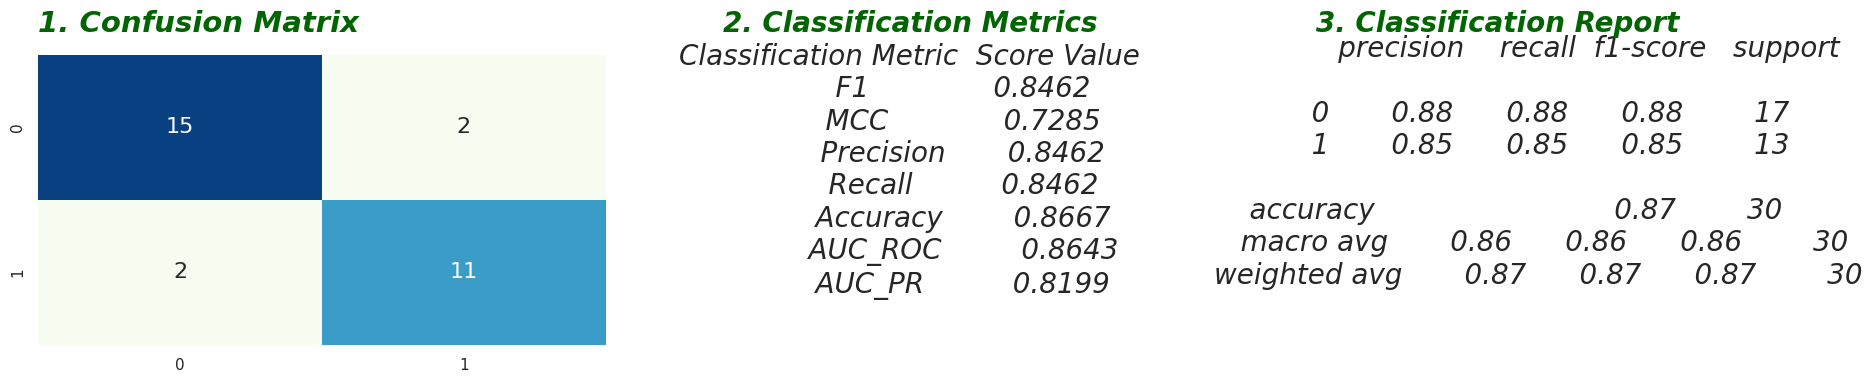

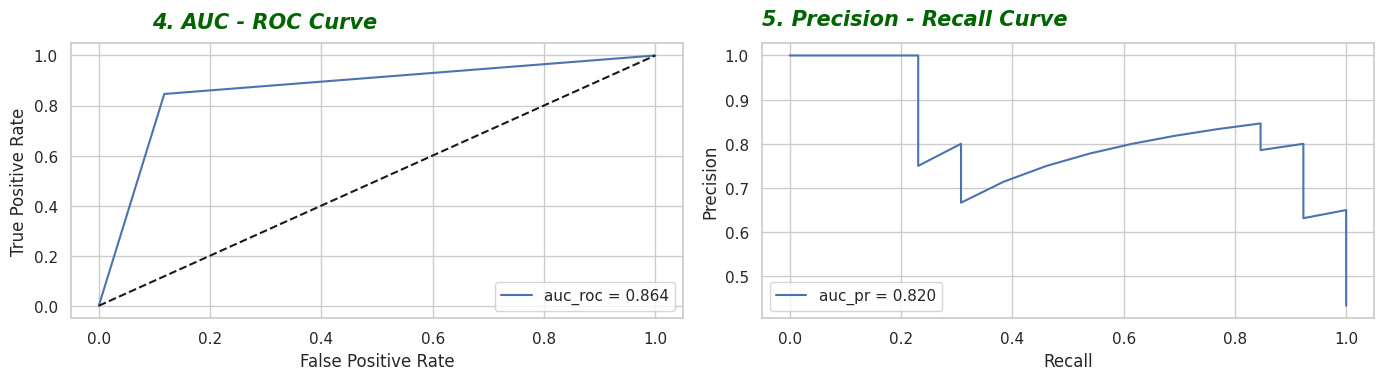

In [58]:
# SVM with Default Parameters and probability = True

svm = SVC(kernel = 'rbf', probability = True, random_state = 100)

svm = svm.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
utils.Generate_Model_Test_Classification_Report(svm, X_test, y_test, model_name="Default Support Vector Machine")

### SVM Hyperparameters Tuning

In [59]:
# GridSearchCV to find best parameters for svm
svm = SVC(kernel = 'rbf', probability = True, random_state = 100)

# parameters to build the model on
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

grid_search = GridSearchCV(estimator = svm, param_grid = param_grid,
                  scoring = 'accuracy', n_jobs = -1, cv = 5, verbose = 2)

# fitting the model for grid search
grid_search.fit(X_train, y_train.values.ravel())

# get the best parameter from gird search
print("Best Parameters:", grid_search.best_params_)

# get the best classifier model after hyper-parameter tuning
print("\nBest Classifier:", grid_search.best_estimator_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters: {'C': 1000, 'gamma': 1}

Best Classifier: SVC(C=1000, gamma=1, probability=True, random_state=100)


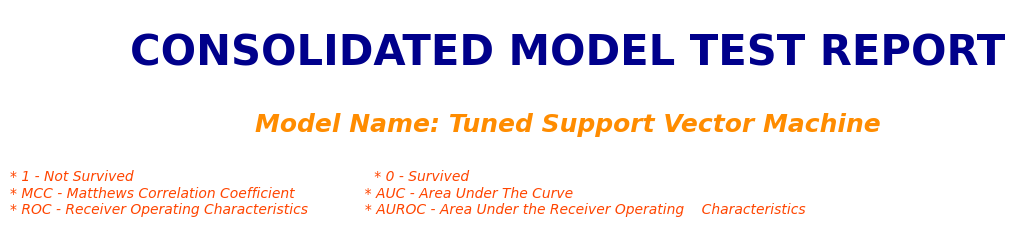

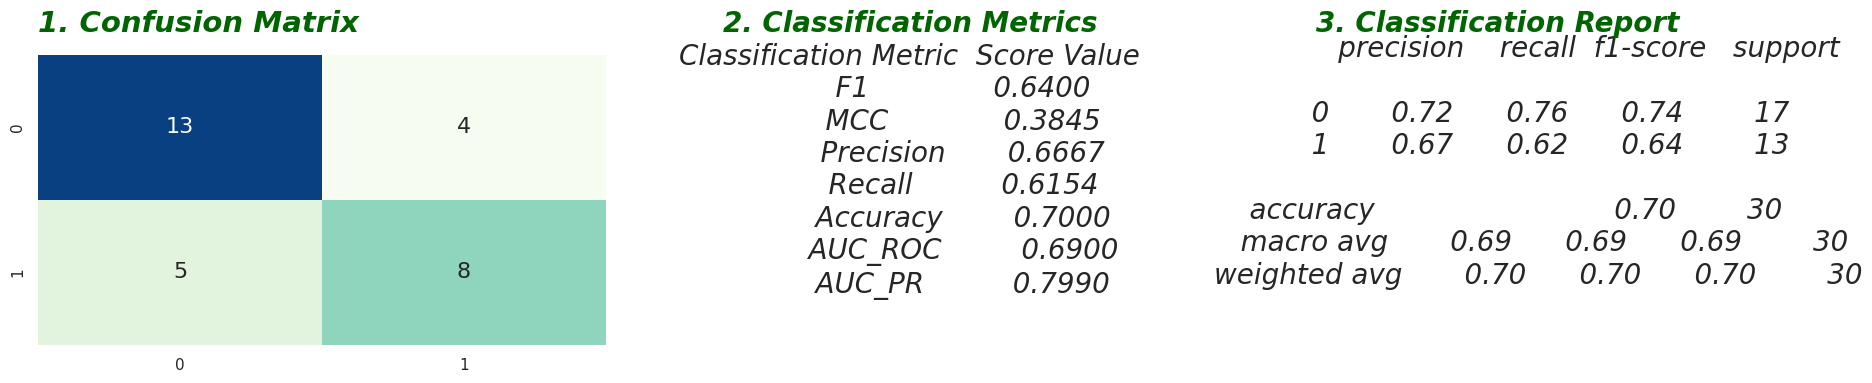

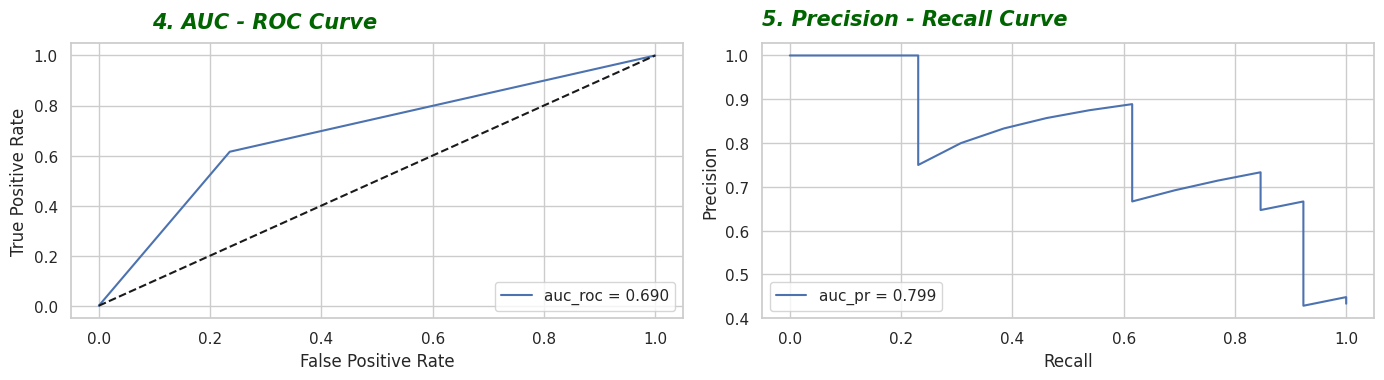

In [60]:
best_svc = grid_search.best_estimator_

best_svc.fit(X_train, y_train.values.ravel())


# Generate the model test classification report
utils.Generate_Model_Test_Classification_Report(best_svc, X_test, y_test, model_name="Tuned Support Vector Machine")

## 2. Decision Tree

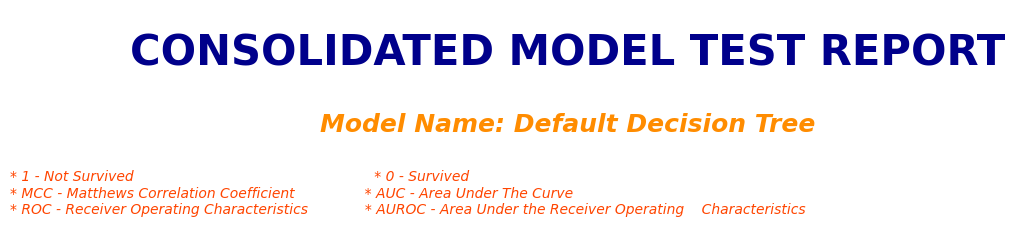

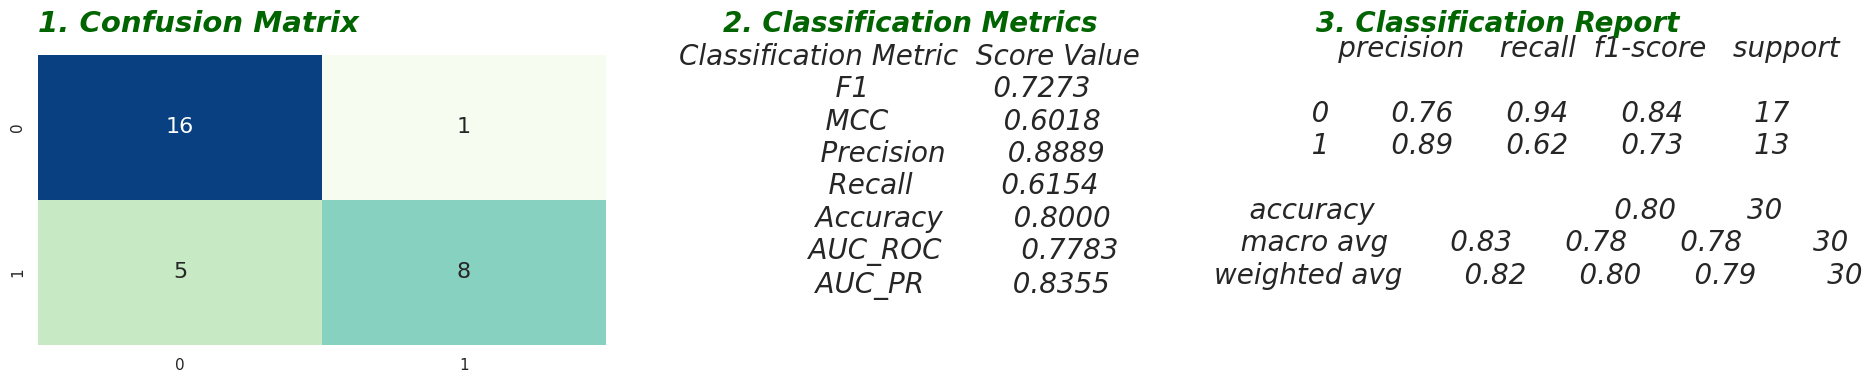

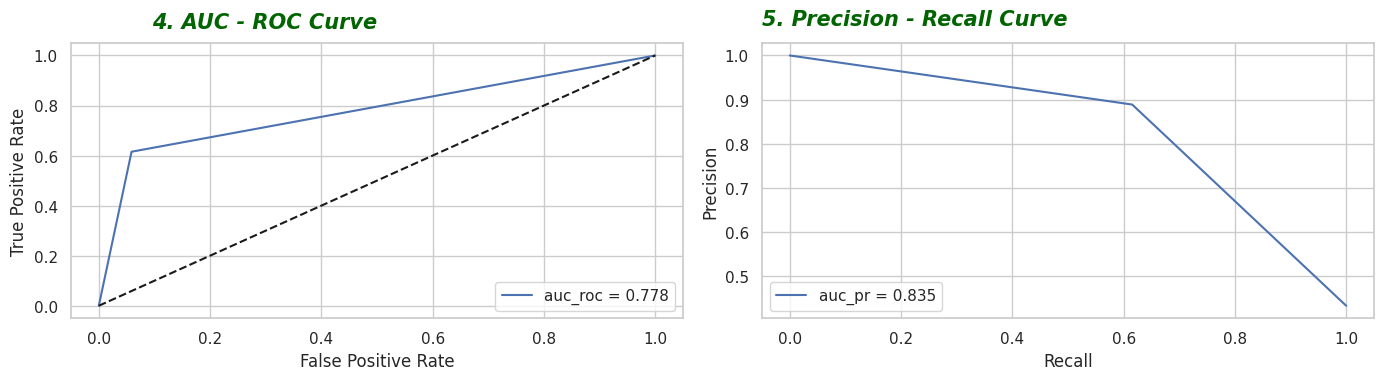

In [61]:
# Decision Tree with Default Parameters

tree = DecisionTreeClassifier(random_state = 100)

tree = tree.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
utils.Generate_Model_Test_Classification_Report(tree, X_test, y_test, model_name="Default Decision Tree")

### Decision Tree Hyperparameters Tuning

In [62]:
# GridSearchCV to find the optimal tree parameters
tree = DecisionTreeClassifier(random_state = 100)

# parameters to build the model on
param_grid = {"max_depth": range(1, 30),
#               "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "min_samples_split":range(2, 10),
              "criterion": ["gini", "entropy"]}

# Instantiating RandomizedSearchCV object
tree_grid = RandomizedSearchCV(tree, param_grid, cv = 5)

# fitting the model for grid search
tree_grid.fit(X_train, y_train.values.ravel())

# get the best parameter from gird search
print("Best Parameters:", tree_grid.best_params_)

# get the best classifier model after hyper-parameter tuning
print("\nBest Classifier:", tree_grid.best_estimator_)

Best Parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 3}

Best Classifier: DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=4,
                       min_samples_split=3, random_state=100)


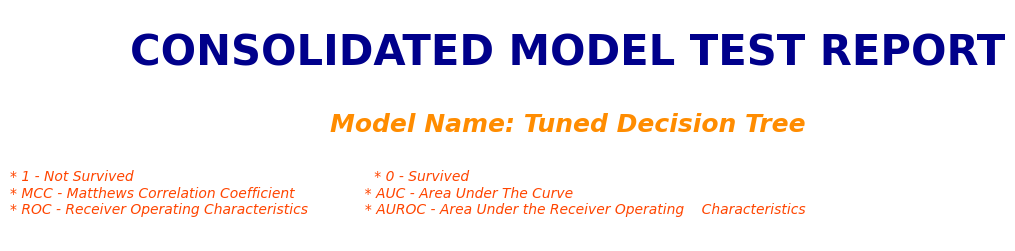

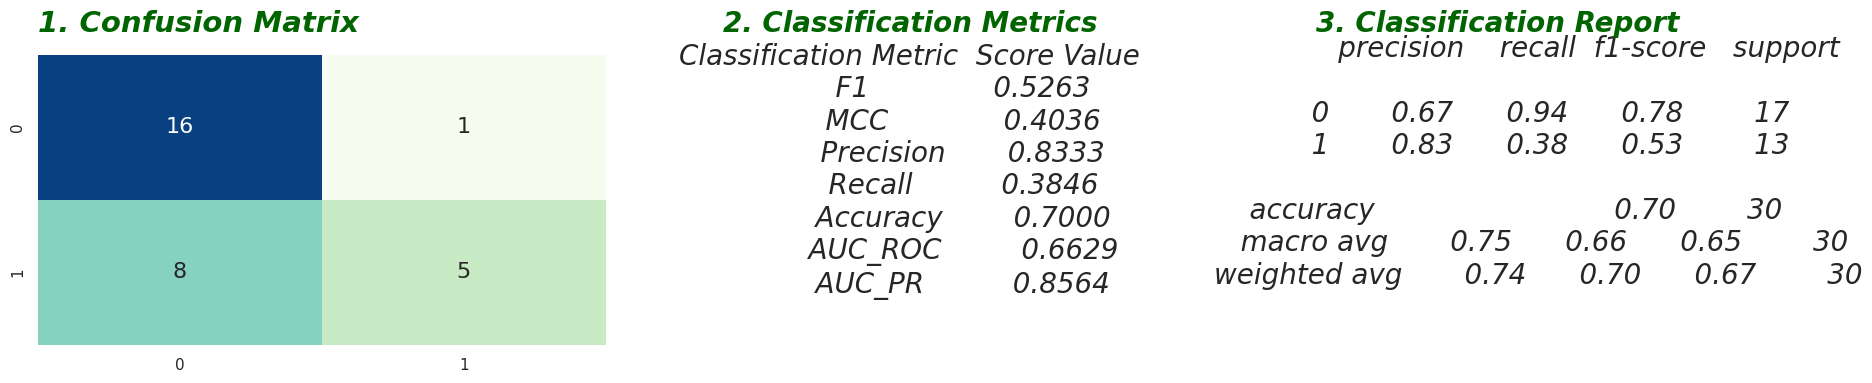

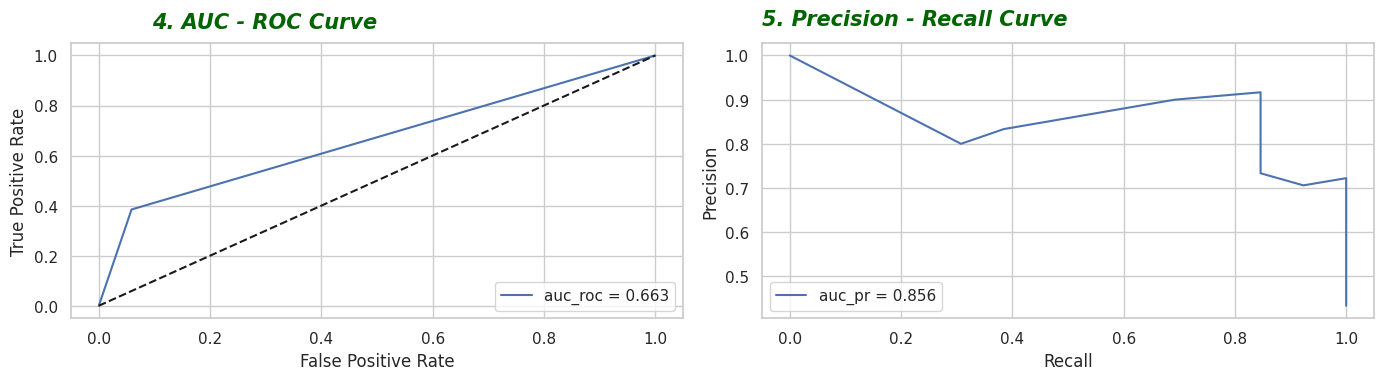

In [63]:
best_tree = tree_grid.best_estimator_

best_tree = best_tree.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
utils.Generate_Model_Test_Classification_Report(best_tree, X_test, y_test, model_name="Tuned Decision Tree")

## 3. Random Forest

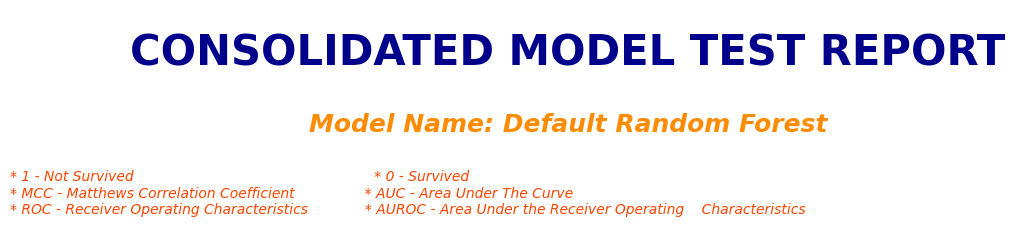

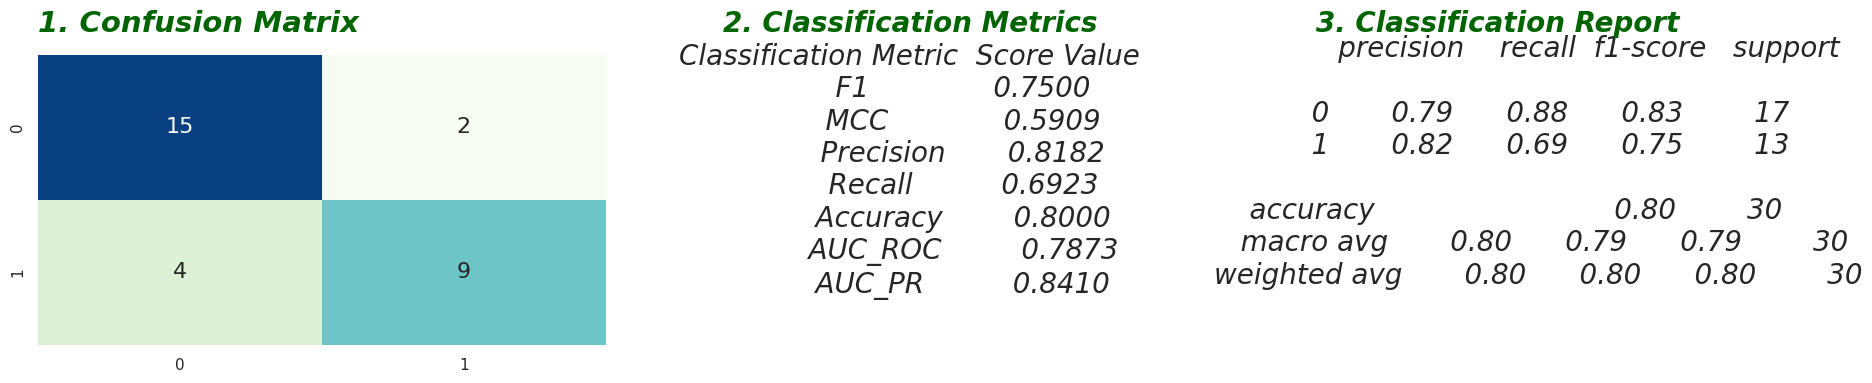

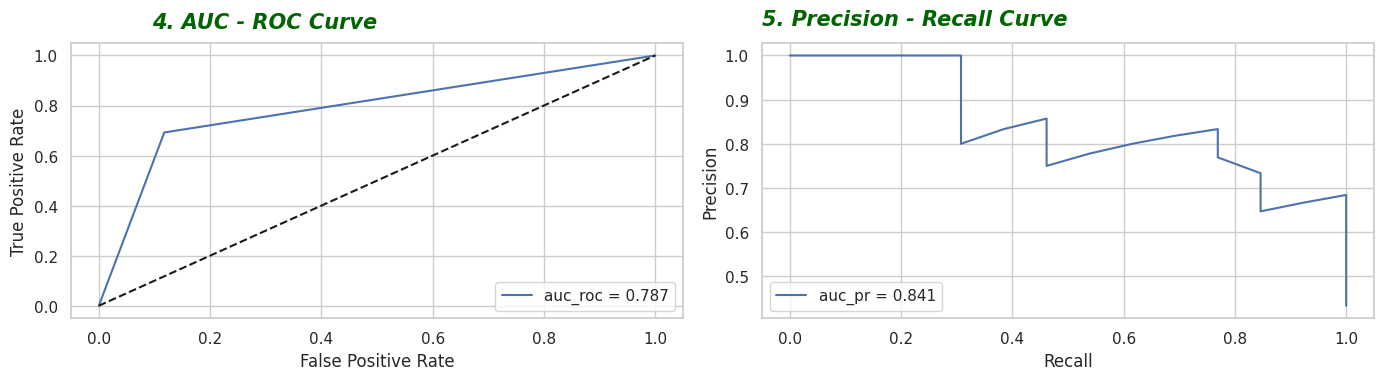

In [64]:
# Random Forest with Default Parameters
rfc = RandomForestClassifier(n_jobs = -1, random_state = 100)

rfc = rfc.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
utils.Generate_Model_Test_Classification_Report(rfc, X_test, y_test, model_name="Default Random Forest")

### Random Forest Hyperparameters Tuning

In [65]:
rn_forest = RandomForestClassifier(n_jobs = -1, random_state = 100)

# parameters to build the model on
param_grid = {"max_depth": range(1, 10),
#               "max_features": randint(1, 3),
              "min_samples_leaf": randint(25, 50),
              "min_samples_split":range(50, 100, 2),
              "n_estimators": range(1000, 8000, 500),
              "bootstrap": [True, False]}

# Instantiating RandomizedSearchCV object
forest_grid = RandomizedSearchCV(rn_forest, param_grid, cv = 5)

# fitting the model for grid search
forest_grid.fit(X_train, y_train.values.ravel())

# get the best parameter from gird search
print("Best Parameters:", forest_grid.best_params_)

# get the best classifier model after hyper-parameter tuning
print("\nBest Classifier:", forest_grid.best_estimator_)

Best Parameters: {'bootstrap': False, 'max_depth': 7, 'min_samples_leaf': 25, 'min_samples_split': 88, 'n_estimators': 6500}

Best Classifier: RandomForestClassifier(bootstrap=False, max_depth=7, min_samples_leaf=25,
                       min_samples_split=88, n_estimators=6500, n_jobs=-1,
                       random_state=100)


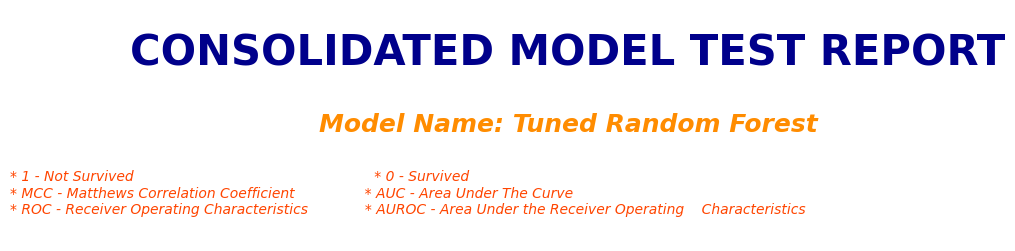

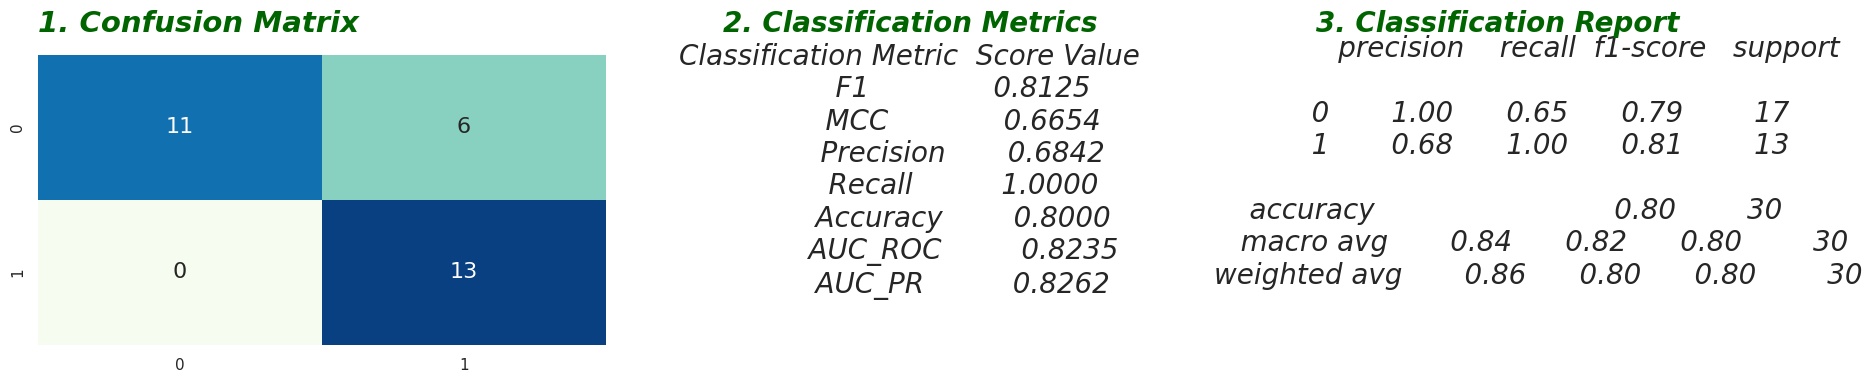

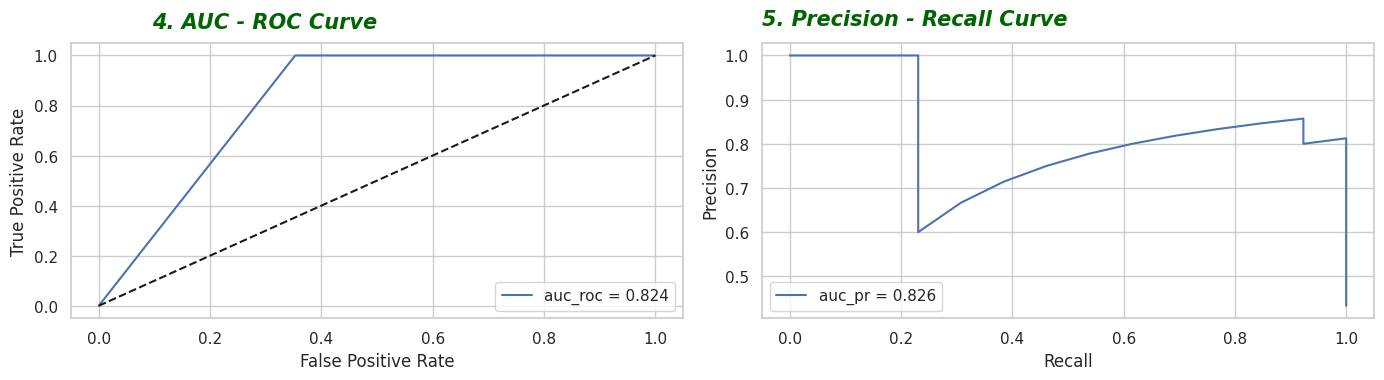

In [66]:
# Random Forest with Best Hypertuned Parameters
best_forest = forest_grid.best_estimator_

best_forest = best_forest.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
utils.Generate_Model_Test_Classification_Report(best_forest, X_test, y_test, model_name="Tuned Random Forest")

## 4. Extreme Gradient Boosting - XGBoost

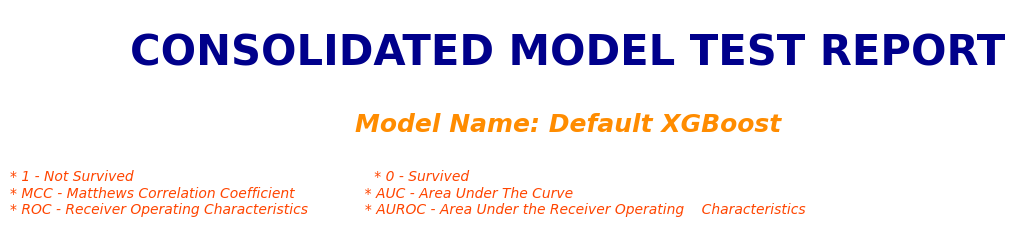

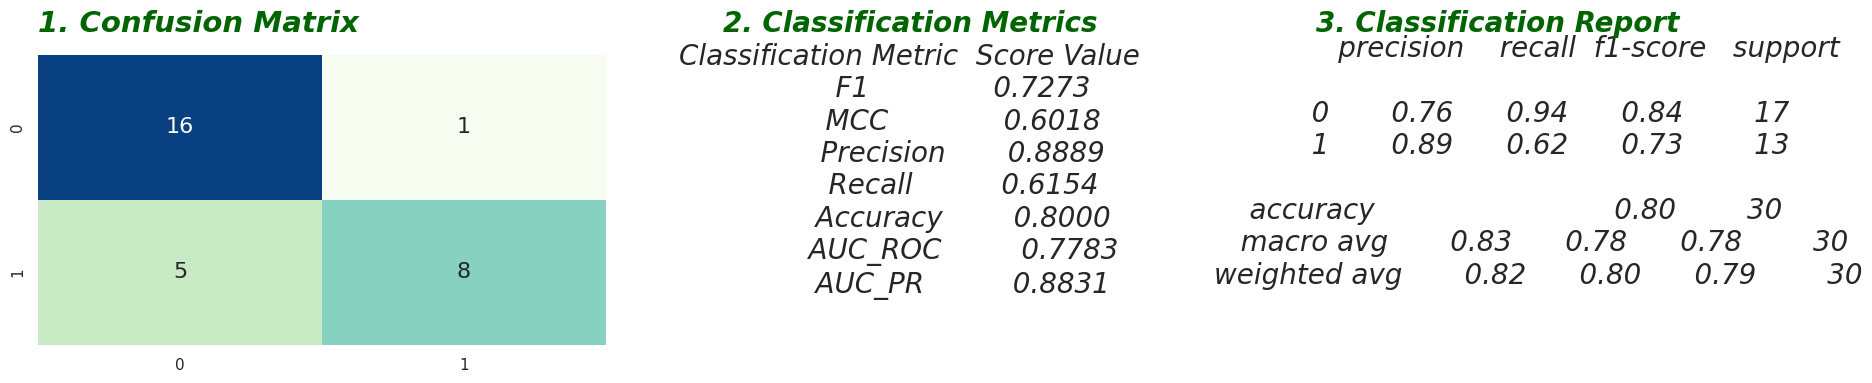

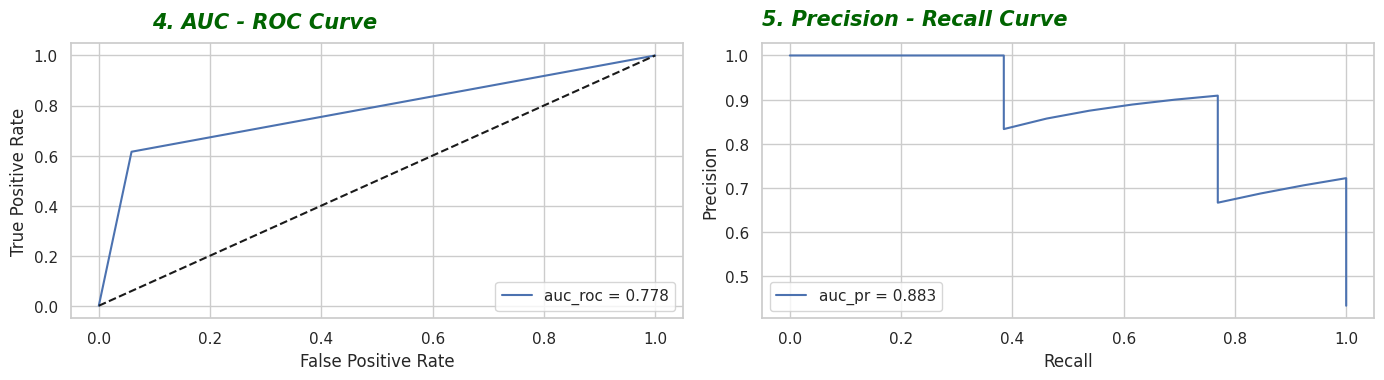

In [67]:
# XGBoost with Default Parameters
xgb = XGBClassifier(n_jobs = -1, random_state = 100)

xgb = xgb.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
utils.Generate_Model_Test_Classification_Report(xgb, X_test, y_test, model_name="Default XGBoost")

In [68]:
# utils.plot_model_feature_importances(X_train, model = xgb)
xgb.feature_importances_

array([0.38019857, 0.36328527, 0.25651616], dtype=float32)

### XG Boost Hyperparameters Tuning

In [69]:
# XGBoost with Default Parameters
xgb = XGBClassifier(n_jobs = -1, random_state = 100)

param_grid = {'max_depth': range(4, 40),
             'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.6, 0.9, 0.95, 0.99],
             'n_estimators': range(100, 1100, 100),
             'min_child_weight': range(1, 11),
             'subsample': np.arange(0.1, 1.1, 0.1),
             'colsample_bytree': np.arange(0.1, 1.1, 0.1)}

# Instantiating RandomizedSearchCV object
xgb_grid = RandomizedSearchCV(xgb, param_grid, cv = 5)

# fitting the model for grid search
xgb_grid.fit(X_train, y_train.values.ravel())

# get the best parameter from gird search
print("Best Parameters:", xgb_grid.best_params_)

# get the best classifier model after hyper-parameter tuning
print("\nBest Classifier:", xgb_grid.best_estimator_)

Best Parameters: {'subsample': np.float64(0.8), 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 24, 'learning_rate': 0.3, 'colsample_bytree': np.float64(0.2)}

Best Classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.2), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=24, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=100, ...)


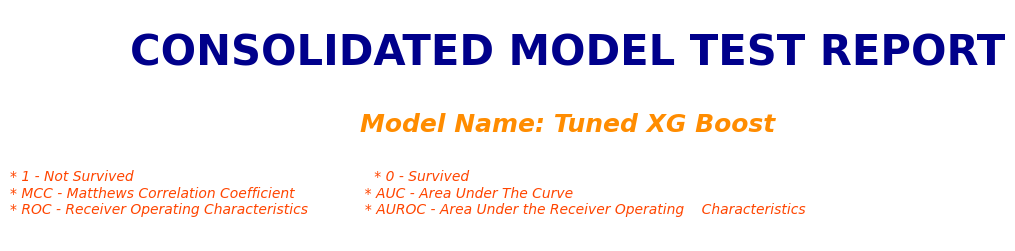

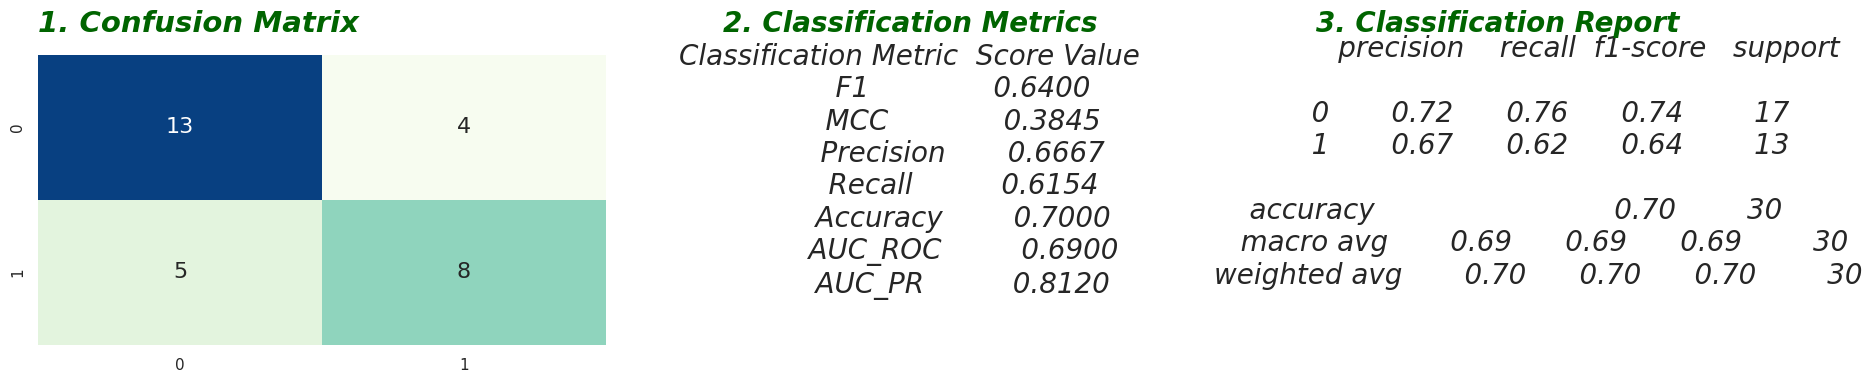

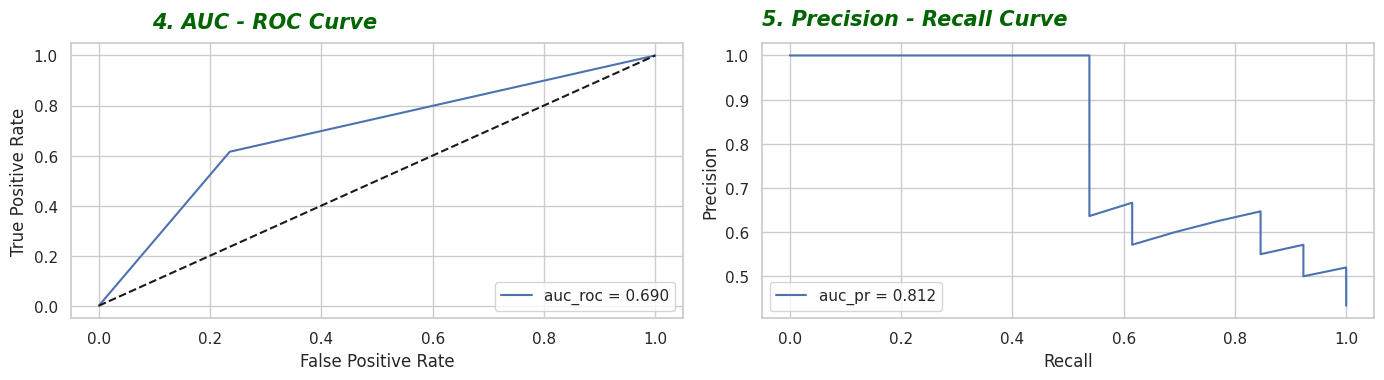

In [70]:
# XG Boost with Best Hypertuned Parameters
best_xgb = xgb_grid.best_estimator_

best_xgb.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
utils.Generate_Model_Test_Classification_Report(best_xgb, X_test, y_test, model_name="Tuned XG Boost")

## 5. Light Gradient Boosted Machine (Light GBM)

[LightGBM] [Info] Number of positive: 186, number of negative: 186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 372, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

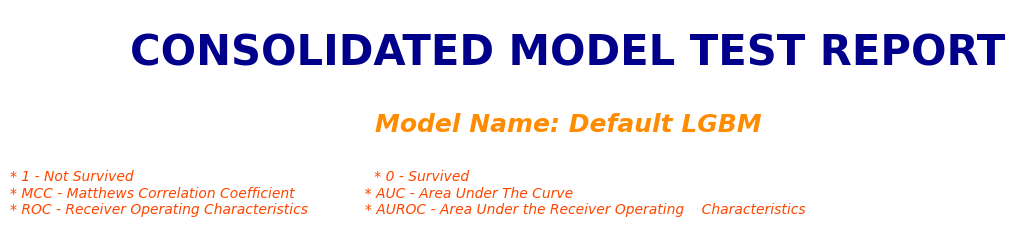

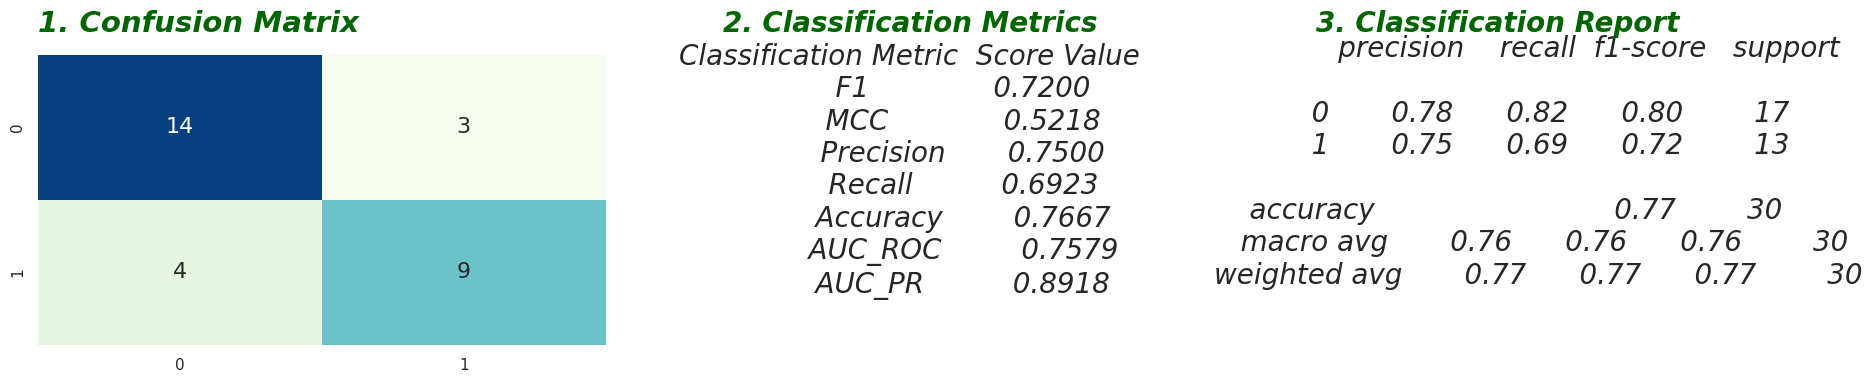

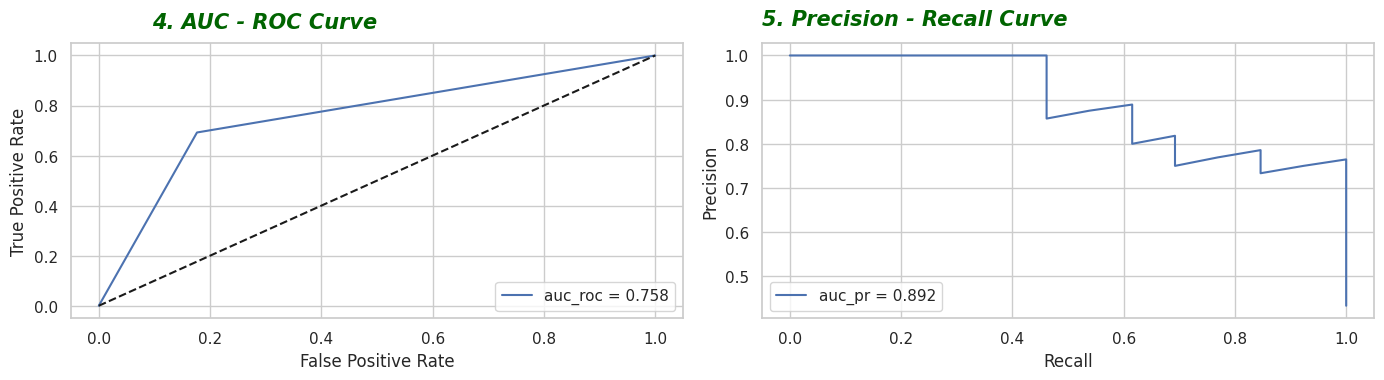

In [71]:
# LightGBM with Default Parameters
lgb = LGBMClassifier(objective = 'binary', n_jobs = -1, random_state = 100)

lgb.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
utils.Generate_Model_Test_Classification_Report(lgb, X_test, y_test, model_name="Default LGBM")

### LGBM Hyperparameter Tuning

In [72]:
# LGBM with Default Parameters
lgb = LGBMClassifier(objective = 'binary', n_jobs = -1, random_state = 100)

param_grid = {'max_depth': range(4, 40),
              'num_leaves': range(20, 100),
              'learning_rate': np.arange(0.1, 1.0, 0.1),
              'n_estimators': range(100, 1100, 100),
              'min_child_samples': range(1, 72),
              'subsample': np.arange(0.1, 1.1, 0.1),
              'colsample_bytree': np.arange(0.1, 1.1, 0.1)}

# Instantiating RandomizedSearchCV object
lgb_grid= RandomizedSearchCV(lgb, param_grid, cv = 5)

# fitting the model for grid search
lgb_grid = lgb_grid.fit(X_train, y_train.values.ravel())

# get the best parameter from gird search
print("Best Parameters:", lgb_grid.best_params_)

# get the best classifier model after hyper-parameter tuning
print("\nBest Classifier:", lgb_grid.best_estimator_)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Info] Number of positive: 186, number of negative: 186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 372, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

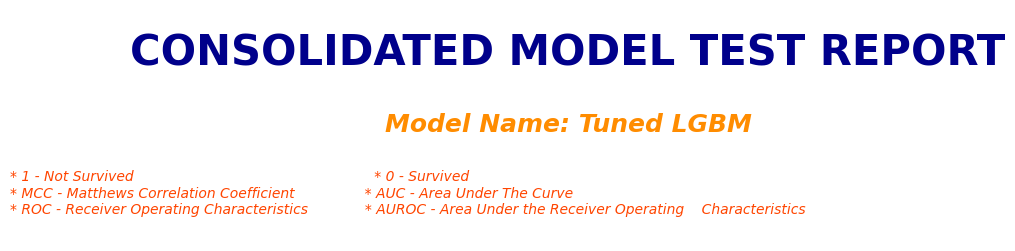

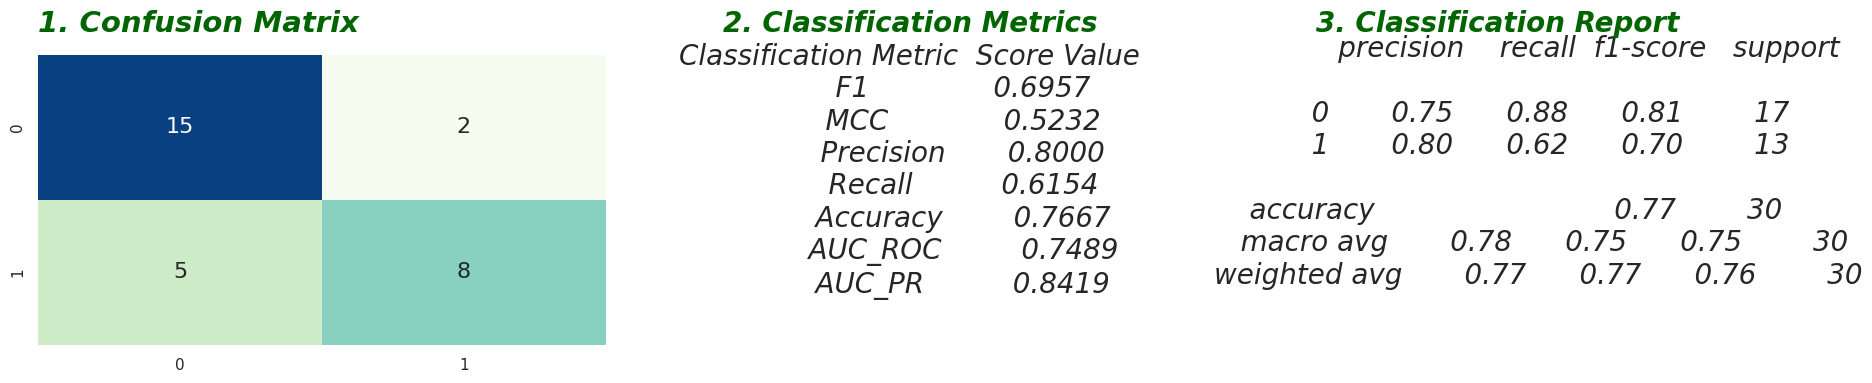

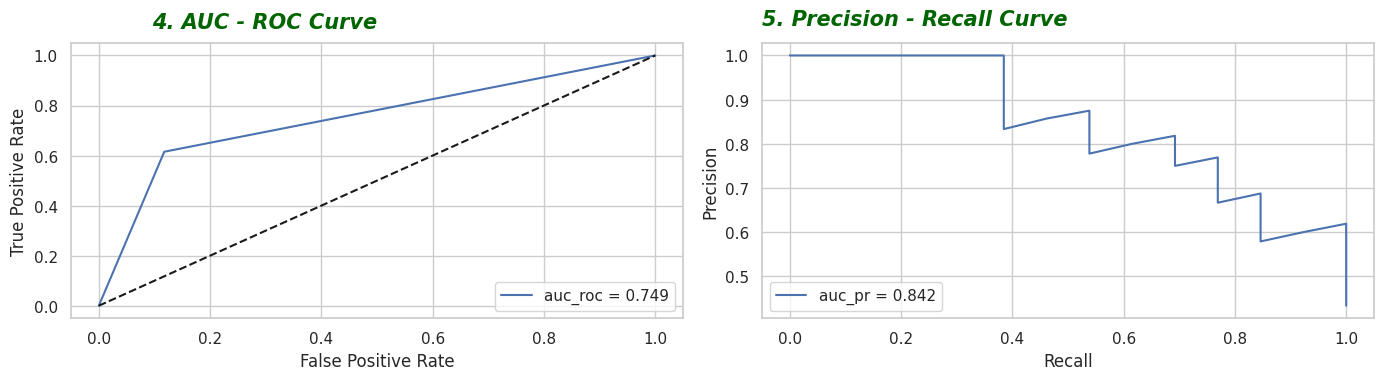

In [73]:
# LGBM with Best Hypertuned Parameters
best_lgb = lgb_grid.best_estimator_

best_lgb.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
utils.Generate_Model_Test_Classification_Report(best_lgb, X_test, y_test, model_name="Tuned LGBM")

**`The above chart shows the impact of the features on the model's output for each class.`**

# Inferences

**`1. 'age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time' seem to be the features that are more closely related to the death event.`**

**`2. The event of a heart failure in the old age could be fatal.`**

**`3. The levels of 'ejection_fraction', 'serum_creatinine', 'serum_sodium' play an important role in the event of heart failure or the abnormalities in the levels of these become an important factor in triggerring heart failure condition.`**

**`4. Random Forest, XGBoost and LightGBM turn out to be the better models in predicting the event of death given the vital parameters that effect heart failure of Cardiovascular conditions.`**

**`5. Machine Learning models can prove to be a time saving factor in predicting the event of death and can help the doctors take additional precauionary measures with critical care.`**

**`6. The imbalance in the dataset had been dealt using the SMOTE oversampling of the minority class. SMOTE balanced the no. of instances for each class but the amount of data is still limited.`**

**`7. The accuracy and model performance can be increased as more data is collected and made available for the model to train on. This data limitation, limits the model performance to some extent. As more and more data becomes available, the prediction accuracy and model's ability to act on other similar real-time data could be enhanced.`**

# Novel Idea 1: Cross-Validation

In the original study, each model was evaluated using a single train-test split, which risks overestimating performance due to random sampling bias. To improve the reliability and fairness of model evaluation, we implement 5-fold stratified cross-validation across all baseline and tuned models.

Cross validation (CV) works by dividing the dataset into k equal parts (folds). In each iteration, one fold is used as the test set while the remaining k−1 folds are used to train the model. This process repeats k times so that every sample is tested exactly once. The performance metrics are then averaged across all folds, producing a more robust and generalizable estimate.

We use stratified CV, which ensures that the distribution of the target class (DEATH_EVENT) is balanced in each fold. This is especially critical in medical datasets where class imbalance (e.g., more survivors than deaths) can skew model evaluation.

By applying this CV strategy uniformly across all 10 models (default and tuned), we create a fair and consistent evaluation environment. This method forms the core of our novel contribution, demonstrating how a more disciplined evaluation framework can reveal the true generalization ability of each model—something not done in the original study.

In [74]:
### Cross-Validation Code Chunk

In [75]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pandas as pd

# Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # X = feature matrix
y = y  # y = labels (DEATH_EVENT)

# Define all 10 models (default + tuned)
models = {
    "SVM Default": SVC(probability=True, random_state=42),
    "SVM Tuned": SVC(C=1000, gamma=1, probability=True, random_state=42),
    "DT Default": DecisionTreeClassifier(random_state=42),
    "DT Tuned": DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=3, min_samples_leaf=1, random_state=42),
    "RF Default": RandomForestClassifier(random_state=42),
    "RF Tuned": RandomForestClassifier(n_estimators=1000, max_depth=2, min_samples_split=96, min_samples_leaf=36, bootstrap=True, random_state=42),
    "XGB Default": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "XGB Tuned": XGBClassifier(use_label_encoder=False, eval_metric='logloss', subsample=0.9, n_estimators=800, min_child_weight=1, max_depth=20, learning_rate=0.95, colsample_bytree=0.9, random_state=42),
    "LGBM Default": LGBMClassifier(random_state=42),
    "LGBM Tuned": LGBMClassifier(subsample=0.2, num_leaves=79, n_estimators=900, min_child_samples=51, max_depth=12, learning_rate=0.3, colsample_bytree=0.9, random_state=42)
}

# Set up 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics
results = {}

for name, model in models.items():
    acc = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy').mean()
    f1 = cross_val_score(model, X_scaled, y, cv=cv, scoring='f1').mean()
    auc = cross_val_score(model, X_scaled, y, cv=cv, scoring='roc_auc').mean()
    results[name] = {
        "Accuracy": round(acc, 4),
        "F1 Score": round(f1, 4),
        "AUC": round(auc, 4)
    }

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [76]:
# Display as DataFrame
results_df = pd.DataFrame(results).T.sort_values(by="AUC", ascending=False)
print("Cross-Validation Results:")
print(results_df)

Cross-Validation Results:
              Accuracy  F1 Score     AUC
RF Default      0.7592    0.5907  0.8097
SVM Default     0.7558    0.5804  0.7926
RF Tuned        0.6956    0.2052  0.7884
LGBM Default    0.7390    0.5810  0.7865
XGB Default     0.7425    0.5969  0.7834
XGB Tuned       0.7424    0.5563  0.7831
LGBM Tuned      0.7493    0.5977  0.7598
DT Tuned        0.7059    0.5098  0.6594
DT Default      0.7057    0.5036  0.6453
SVM Tuned       0.6790    0.4365  0.6240


In [77]:
### Comparison for Original and CV Scores

In [78]:
import pandas as pd

original_results = {
    "SVM Default":      {"Accuracy": 0.867, "F1 Score": 0.846, "AUC": 0.8643},
    "SVM Tuned":        {"Accuracy": 0.733, "F1 Score": 0.667, "AUC": 0.7195},
    "DT Default":       {"Accuracy": 0.800, "F1 Score": 0.727, "AUC": 0.7783},
    "DT Tuned":         {"Accuracy": 0.667, "F1 Score": 0.500, "AUC": 0.6335},
    "RF Default":       {"Accuracy": 0.800, "F1 Score": 0.750, "AUC": 0.7873},
    "RF Tuned":         {"Accuracy": 0.800, "F1 Score": 0.812, "AUC": 0.8235},
    "XGB Default":      {"Accuracy": 0.767, "F1 Score": 0.667, "AUC": 0.7398},
    "XGB Tuned":        {"Accuracy": 0.767, "F1 Score": 0.696, "AUC": 0.7489},
    "LGBM Default":     {"Accuracy": 0.767, "F1 Score": 0.720, "AUC": 0.7579},
    "LGBM Tuned":       {"Accuracy": 0.733, "F1 Score": 0.692, "AUC": 0.7285}
}

original_df = pd.DataFrame(original_results).T
original_df.to_csv("original_results.csv")


In [79]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Load original results
original_df = pd.read_csv("original_results.csv", index_col=0)
original_df.columns = [f"Original {col}" for col in original_df.columns]

# Prepare models
models = {
    "SVM Default": SVC(probability=True, random_state=42),
    "SVM Tuned": SVC(C=1000, gamma=1, probability=True, random_state=42),
    "DT Default": DecisionTreeClassifier(random_state=42),
    "DT Tuned": DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=3, min_samples_leaf=1, random_state=42),
    "RF Default": RandomForestClassifier(random_state=42),
    "RF Tuned": RandomForestClassifier(n_estimators=1000, max_depth=2, min_samples_split=96, min_samples_leaf=36, bootstrap=True, random_state=42),
    "XGB Default": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "XGB Tuned": XGBClassifier(use_label_encoder=False, eval_metric='logloss', subsample=0.9, n_estimators=800, min_child_weight=1, max_depth=20, learning_rate=0.95, colsample_bytree=0.9, random_state=42),
    "LGBM Default": LGBMClassifier(random_state=42),
    "LGBM Tuned": LGBMClassifier(subsample=0.2, num_leaves=79, n_estimators=900, min_child_samples=51, max_depth=12, learning_rate=0.3, colsample_bytree=0.9, random_state=42)
}

# Preprocess data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Make sure X and y are defined
y = y

# Run cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in models.items():
    acc = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy').mean()
    f1 = cross_val_score(model, X_scaled, y, cv=cv, scoring='f1').mean()
    auc = cross_val_score(model, X_scaled, y, cv=cv, scoring='roc_auc').mean()
    cv_results[name] = {
        "CV Accuracy": round(acc, 4),
        "CV F1 Score": round(f1, 4),
        "CV AUC": round(auc, 4)
    }

cv_df = pd.DataFrame(cv_results).T

# Combine both sets of results
comparison_df = pd.concat([original_df, cv_df], axis=1)
comparison_df = comparison_df.round(4).sort_values("CV AUC", ascending=False)


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [80]:
# Display Original and CV Scores
print("Original vs Cross-Validated Scores")
print(comparison_df)

Original vs Cross-Validated Scores
              Original Accuracy  Original F1 Score  Original AUC  CV Accuracy  CV F1 Score  CV AUC
RF Default                0.800              0.750        0.7873       0.7592       0.5907  0.8097
SVM Default               0.867              0.846        0.8643       0.7558       0.5804  0.7926
RF Tuned                  0.800              0.812        0.8235       0.6956       0.2052  0.7884
LGBM Default              0.767              0.720        0.7579       0.7390       0.5810  0.7865
XGB Default               0.767              0.667        0.7398       0.7425       0.5969  0.7834
XGB Tuned                 0.767              0.696        0.7489       0.7424       0.5563  0.7831
LGBM Tuned                0.733              0.692        0.7285       0.7493       0.5977  0.7598
DT Tuned                  0.667              0.500        0.6335       0.7059       0.5098  0.6594
DT Default                0.800              0.727        0.7783       0.7

## Novelty Idea 2
ensemble learning and Voting Classifiers

In [81]:
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

# 1. Create two voting classifiers

# All models voting classifier
all_models_voting = VotingClassifier(
    estimators=[(name, clone(model)) for name, model in models.items()],
    voting='soft'
)

# Selective voting classifier (top 4 models by AUC)
selective_models = {
    "RF Default": clone(models["RF Default"]),
    "SVM Default": clone(models["SVM Default"]),
    "RF Tuned": clone(models["RF Tuned"]),
    "LGBM Default": clone(models["LGBM Default"])
}

selective_voting = VotingClassifier(
    estimators=list(selective_models.items()),
    voting='soft'
)

# 2. Evaluation function
def evaluate_voting(voting_clf, X, y, cv, name):
    # Create pipeline with scaling
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('voting', voting_clf)
    ])

    # Get cross-validated metrics
    acc = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy').mean()
    f1 = cross_val_score(pipe, X, y, cv=cv, scoring='f1').mean()
    auc = cross_val_score(pipe, X, y, cv=cv, scoring='roc_auc').mean()

    return {
        name: {
            "Accuracy": round(acc, 4),
            "F1 Score": round(f1, 4),
            "AUC": round(auc, 4)
        }
    }

# 3. Evaluate both voting classifiers
voting_results = {}

# Evaluate all models voting
all_models_result = evaluate_voting(all_models_voting, X, y, cv,
                                  "Soft Voting (All Models)")
voting_results.update(all_models_result)

# Evaluate selective voting
selective_result = evaluate_voting(selective_voting, X, y, cv,
                                 "Soft Voting (Top 4 Models)")
voting_results.update(selective_result)

# 4. Combine with individual model results
all_results = {**results, **voting_results}

# 5. Display sorted results
results_df = pd.DataFrame(all_results).T
print(results_df.sort_values(by='AUC', ascending=False))

# 6. Optional: Add weighted voting (example)
selective_voting_weighted = VotingClassifier(
    estimators=list(selective_models.items()),
    voting='soft',
    weights=[2, 1, 1.5, 1]  # RF Default gets double weight
)

weighted_result = evaluate_voting(selective_voting_weighted, X, y, cv,
                                "Weighted Voting (Top 4)")
all_results.update(weighted_result)

# Display final results
final_results_df = pd.DataFrame(all_results).T
print("\nFinal Results with Weighted Voting:")
print(final_results_df.sort_values(by='AUC', ascending=False))

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

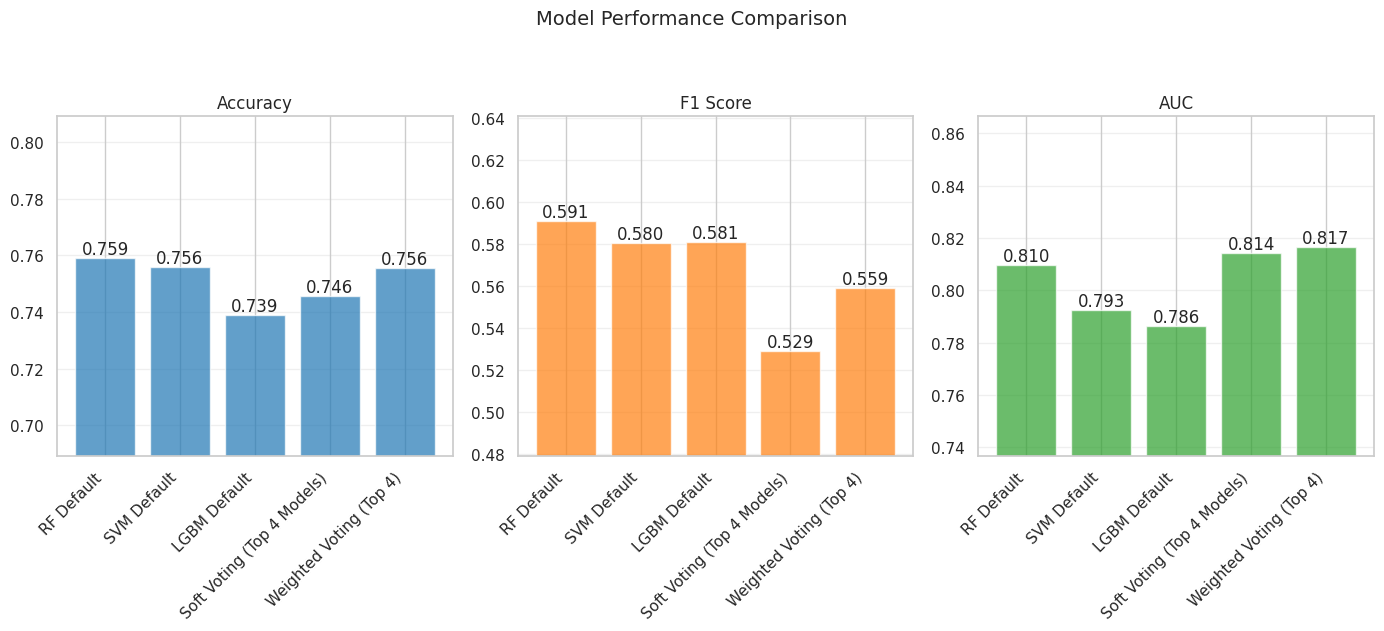

In [83]:
plt.figure(figsize=(14, 6))

# Prepare data
models_compare = ['RF Default', 'SVM Default', 'LGBM Default',
                 'Soft Voting (Top 4 Models)', 'Weighted Voting (Top 4)']
metrics = ['Accuracy', 'F1 Score', 'AUC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Create subplots
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    values = [all_results[model][metric] for model in models_compare]
    bars = plt.bar(models_compare, values, color=colors[i], alpha=0.7)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

    plt.title(metric)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(min(values)-0.05, max(values)+0.05)
    plt.grid(True, axis='y', alpha=0.3)

plt.suptitle('Model Performance Comparison', y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

#
# Novelty Idea 3

implementaion of Divide-and-Conquer + SMOTE+ Local Classifiers

In [84]:
# 1. Import Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# --- Google Colab Specific ---
from google.colab import files  # For uploading files
import os  # For file path manipulation
# from google.colab import drive # For mounting Google Drive (optional)
# ----------------------------

# 2. Load and Preprocess Data
def load_data(filepath=None):
    """
    Loads the dataset.

    Args:
        filepath (str, optional): The path to the CSV file. If None, assumes
                                  the user will upload the file.

    Returns:
        pd.DataFrame: The loaded DataFrame.
    """
    if filepath:
        return pd.read_csv(filepath)
    else:
        uploaded = files.upload()  # Opens file upload dialog in Colab
        filename = list(uploaded.keys())[0]  # Get the filename
        return pd.read_csv(filename)


def preprocess_data(df, target_column="DEATH_EVENT"):
    """
    Selects features and prepares data for modeling.

    Args:
        df (pd.DataFrame): The input DataFrame.
        target_column (str): The name of the target column.

    Returns:
        tuple: (features (pd.DataFrame), target variable (pd.Series))
    """

    features = [
        "age", "ejection_fraction", "serum_creatinine",
        "serum_sodium", "platelets", "creatinine_phosphokinase",
        "high_blood_pressure", "anaemia", "diabetes", "smoking"
    ]
    X = df[features]
    y = df[target_column]
    return X, y


# 3. Clustering
def cluster_data(X, n_clusters=3, random_state=42):
    """
    Clusters the data using KMeans.

    Args:
        X (pd.DataFrame): The feature data.
        n_clusters (int): The number of clusters.
        random_state (int): Random state for reproducibility.

    Returns:
        tuple: (clustered data with cluster labels (pd.DataFrame), trained KMeans model)
    """

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(X_scaled)
    X_clustered = X.copy()
    X_clustered['cluster'] = clusters
    return X_clustered, kmeans


# 4. SMOTE within Clusters
def apply_smote_to_clusters(X_clustered, y, test_size=0.3, random_state=42):
    """
    Applies SMOTE to the training data within each cluster.

    Args:
        X_clustered (pd.DataFrame): The feature data with cluster labels.
        y (pd.Series): The target variable.
        test_size (float): Proportion of data to use for testing.
        random_state (int): Random state for reproducibility.

    Returns:
        tuple: (lists of X_train, y_train, X_test, y_test, and scalers)
    """

    X_train_all, y_train_all, X_test_all, y_test_all, scalers = [], [], [], [], []

    for cluster_id in X_clustered['cluster'].unique():
        X_cluster = X_clustered[X_clustered['cluster'] == cluster_id].drop(columns=['cluster'])
        y_cluster = y[X_clustered.index.isin(X_cluster.index)]

        X_train, X_test, y_train, y_test = train_test_split(
            X_cluster, y_cluster, test_size=test_size, random_state=random_state, stratify=y_cluster
        )

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        smote = SMOTE(random_state=random_state)
        X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

        X_train_all.append(X_resampled)
        y_train_all.append(y_resampled)
        X_test_all.append(X_test_scaled)
        y_test_all.append(y_test)
        scalers.append(scaler)

    return X_train_all, y_train_all, X_test_all, y_test_all, scalers


# 5. Local Classifier Training
def train_local_classifiers(X_train_all, y_train_all, random_state=42):
    """
    Trains a separate Random Forest classifier for each cluster.

    Args:
        X_train_all (list): List of training feature data for each cluster.
        y_train_all (list): List of training target data for each cluster.
        random_state (int): Random state for reproducibility.

    Returns:
        dict: Dictionary of trained models (one per cluster).
    """

    models = {}
    for i in range(len(X_train_all)):
        model = RandomForestClassifier(random_state=random_state)
        model.fit(X_train_all[i], y_train_all[i])
        models[i] = model
    return models


# 6. Prediction
def predict_patient_risk(patient_data, kmeans_model, scalers, models, features):
    """
    Predicts heart failure risk for a single patient using the clustered model.

    Args:
        patient_data (pd.Series): Patient data.
        kmeans_model: Trained KMeans model.
        scalers: List of scalers (one per cluster).
        models: Dictionary of trained classification models (one per cluster).
        features (list): List of feature names used for training.

    Returns:
        tuple: (predicted risk, cluster assignment)
    """

    patient_features = patient_data[features].values.reshape(1, -1)
    patient_scaled_for_clustering = StandardScaler().fit_transform(patient_data[features].values.reshape(1, -1))
    cluster = kmeans_model.predict(patient_scaled_for_clustering)[0]

    scaler = scalers[cluster]
    patient_scaled_for_cluster = scaler.transform(patient_features)

    model = models[cluster]
    prediction = model.predict(patient_scaled_for_cluster)
    return prediction, cluster


# 7. Evaluation
def evaluate_model(models, X_test_all, y_test_all):
    """
    Evaluates the performance of the models on the test sets.

    Args:
        models (dict): Dictionary of trained models (one per cluster).
        X_test_all (list): List of testing feature data for each cluster.
        y_test_all (list): List of testing target data for each cluster.
    """

    for i in range(len(X_test_all)):
        print(f"\n--- Cluster {i} Evaluation ---")
        y_pred = models[i].predict(X_test_all[i])
        print("Classification Report:\n", classification_report(y_test_all[i], y_pred))
        print("Confusion Matrix:\n", confusion_matrix(y_test_all[i], y_pred))
        print(f"ROC AUC Score: {roc_auc_score(y_test_all[i], models[i].predict_proba(X_test_all[i])[:, 1])}")


# 8. Main Execution Block
if __name__ == "__main__":
    # Load data
    data = load_data()  # No filepath provided, so it will prompt for upload

    # Preprocess data
    X, y = preprocess_data(data)

    # Cluster data
    X_clustered, kmeans_model = cluster_data(X)

    # Apply SMOTE
    X_train_all, y_train_all, X_test_all, y_test_all, scalers = apply_smote_to_clusters(X_clustered, y)

    # Train local classifiers
    models = train_local_classifiers(X_train_all, y_train_all)

    # Evaluate the model
    evaluate_model(models, X_test_all, y_test_all)

    # Example Prediction (Illustrative)
    # Assuming you have a new patient's data in 'new_patient' (a pandas Series)
    # new_patient = pd.Series({...})  # Create a Series with patient data
    # prediction, cluster_assignment = predict_patient_risk(new_patient, kmeans_model, scalers, models, X.columns)
    # print(f"\nPredicted risk: {prediction}, Assigned to cluster: {cluster_assignment}")

Saving heart_failure_clinical_records_dataset.csv to heart_failure_clinical_records_dataset (1).csv
Saving ReusableUtils.py to ReusableUtils (1).py
Saving SurvivalAnalysisUtils.py to SurvivalAnalysisUtils (1).py

--- Cluster 0 Evaluation ---
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.88      0.64      0.74        11

    accuracy                           0.74        19
   macro avg       0.76      0.76      0.74        19
weighted avg       0.77      0.74      0.74        19

Confusion Matrix:
 [[7 1]
 [4 7]]
ROC AUC Score: 0.8295454545454545

--- Cluster 1 Evaluation ---
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84        30
           1       0.25      0.12      0.17         8

    accuracy                           0.74        38
   macro avg       0.52      0.51      0.51        38
weighted avg 

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# --- Data Loading and Preprocessing (Use the SAME functions as before!) ---
def load_data(filepath=None):
    if filepath:
        return pd.read_csv(filepath)
    else:
        from google.colab import files
        uploaded = files.upload()
        filename = list(uploaded.keys())[0]
        return pd.read_csv(filename)

def preprocess_data(df, target_column="DEATH_EVENT"):
    features = [
        "age", "ejection_fraction", "serum_creatinine",
        "serum_sodium", "platelets", "creatinine_phosphokinase",
        "high_blood_pressure", "anaemia", "diabetes", "smoking"
    ]
    X = df[features]
    y = df[target_column]
    return X, y
# -----------------------------------------------------------------------

# Load and preprocess data
data = load_data()
X, y = preprocess_data(data)

# Split data (CRUCIAL: Use the SAME split as in your clustered approach!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale data (CRUCIAL: Use the SAME scaling as in your clustered approach!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Train a Global Random Forest Model ---
global_rf = RandomForestClassifier(random_state=42)  # Same random_state for consistency
global_rf.fit(X_train_scaled, y_train)

# --- Evaluate the Global Model ---
print("\n--- Global Random Forest ---")
y_pred_global = global_rf.predict(X_test_scaled)
print(classification_report(y_test, y_pred_global))
print(confusion_matrix(y_test, y_pred_global))
print(f"ROC AUC Score: {roc_auc_score(y_test, global_rf.predict_proba(X_test_scaled)[:, 1])}")

Saving heart_failure_clinical_records_dataset.csv to heart_failure_clinical_records_dataset (2).csv
Saving ReusableUtils.py to ReusableUtils (2).py
Saving SurvivalAnalysisUtils.py to SurvivalAnalysisUtils (2).py

--- Global Random Forest ---
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        61
           1       0.62      0.55      0.58        29

    accuracy                           0.74        90
   macro avg       0.71      0.69      0.70        90
weighted avg       0.74      0.74      0.74        90

[[51 10]
 [13 16]]
ROC AUC Score: 0.787167891464104


In [86]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- Global Random Forest Results (from your provided output) ---
global_rf_results = {
    "Accuracy": 0.74,
    "Precision_Class_1": 0.62,
    "Recall_Class_1": 0.55,
    "F1_Score_Class_1": 0.58,
    "ROC_AUC": 0.787,
    "TN": 51,
    "FP": 10,
    "FN": 13,
    "TP": 16
}

# --- Clustered Model Results (from your provided output) ---
cluster_results = {
    "Cluster_0": {
        "Accuracy": 0.74,
        "Precision_Class_1": 0.88,
        "Recall_Class_1": 0.64,
        "F1_Score_Class_1": 0.74,
        "ROC_AUC": 0.8295,
        "TN": 7,
        "FP": 1,
        "FN": 4,
        "TP": 7
    },
    "Cluster_1": {
        "Accuracy": 0.74,
        "Precision_Class_1": 0.25,
        "Recall_Class_1": 0.12,
        "F1_Score_Class_1": 0.17,
        "ROC_AUC": 0.5896,
        "TN": 27,
        "FP": 3,
        "FN": 7,
        "TP": 1
    },
    "Cluster_2": {
        "Accuracy": 0.74,
        "Precision_Class_1": 0.62,
        "Recall_Class_1": 0.45,
        "F1_Score_Class_1": 0.53,
        "ROC_AUC": 0.7292,
        "TN": 21,
        "FP": 3,
        "FN": 6,
        "TP": 5
    }
}

# --- Create DataFrames for Comparison ---

# Global Model DataFrame
global_df = pd.DataFrame(global_rf_results, index=[0])

# Clustered Model DataFrame
cluster_df = pd.DataFrame(cluster_results).T  # Transpose to have clusters as rows

# --- Print Comparison Tables ---

print("--- Global Random Forest Model Results ---")
print(global_df.to_markdown(index=False, numalign="left", stralign="left"))

print("\n--- Clustered Model Results ---")
print(cluster_df.to_markdown(numalign="left", stralign="left"))


# --- Combined Comparison Table (for key metrics) ---
combined_data = {
    "Metric": ["Accuracy", "Precision (Class 1)", "Recall (Class 1)", "F1-Score (Class 1)", "ROC AUC"],
    "Global RF": [global_rf_results[metric] for metric in ["Accuracy", "Precision_Class_1", "Recall_Class_1", "F1_Score_Class_1", "ROC_AUC"]],
    "Cluster 0": [cluster_results["Cluster_0"][metric] for metric in ["Accuracy", "Precision_Class_1", "Recall_Class_1", "F1_Score_Class_1", "ROC_AUC"]],
    "Cluster 1": [cluster_results["Cluster_1"][metric] for metric in ["Accuracy", "Precision_Class_1", "Recall_Class_1", "F1_Score_Class_1", "ROC_AUC"]],
    "Cluster 2": [cluster_results["Cluster_2"][metric] for metric in ["Accuracy", "Precision_Class_1", "Recall_Class_1", "F1_Score_Class_1", "ROC_AUC"]]
}

combined_df = pd.DataFrame(combined_data)

print("\n--- Combined Comparison of Key Metrics ---")
print(combined_df.to_markdown(index=False, numalign="left", stralign="left"))

--- Global Random Forest Model Results ---
| Accuracy   | Precision_Class_1   | Recall_Class_1   | F1_Score_Class_1   | ROC_AUC   | TN   | FP   | FN   | TP   |
|:-----------|:--------------------|:-----------------|:-------------------|:----------|:-----|:-----|:-----|:-----|
| 0.74       | 0.62                | 0.55             | 0.58               | 0.787     | 51   | 10   | 13   | 16   |

--- Clustered Model Results ---
|           | Accuracy   | Precision_Class_1   | Recall_Class_1   | F1_Score_Class_1   | ROC_AUC   | TN   | FP   | FN   | TP   |
|:----------|:-----------|:--------------------|:-----------------|:-------------------|:----------|:-----|:-----|:-----|:-----|
| Cluster_0 | 0.74       | 0.88                | 0.64             | 0.74               | 0.8295    | 7    | 1    | 4    | 7    |
| Cluster_1 | 0.74       | 0.25                | 0.12             | 0.17               | 0.5896    | 27   | 3    | 7    | 1    |
| Cluster_2 | 0.74       | 0.62                | 0.45    